# Distracted Driver Detection 🚗🪪

This project is based on detecting whether a driver is focused while driving or doing some other task

## Import Libraries and Explore data 🔍

In [6]:
#The dataset can be downloaded from the following link :- https://www.kaggle.com/competitions/state-farm-distracted-driver-detection/data
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os

In [7]:
#Unzip data
zip_ref = zipfile.ZipFile('driver_distraction.zip')
zip_ref.extractall()

In [8]:
#All data in in the /train directory so lets see it
for dirpath, dirnames, filenames in os.walk('/content/train'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 10 directories and 0 images in /content/train
There are 0 directories and 2312 images in /content/train/c5
There are 0 directories and 2267 images in /content/train/c1
There are 0 directories and 2346 images in /content/train/c3
There are 0 directories and 2317 images in /content/train/c2
There are 0 directories and 2129 images in /content/train/c9
There are 0 directories and 2325 images in /content/train/c6
There are 0 directories and 1911 images in /content/train/c8
There are 0 directories and 2489 images in /content/train/c0
There are 0 directories and 2002 images in /content/train/c7
There are 0 directories and 2326 images in /content/train/c4


There are about 2000 images for each class, but what do these classes mean? Here's a list of what each class actually is 

- **c0**: safe driving
- **c1**: texting - right
- **c2**: talking on the phone - right
- **c3**: texting - left
- **c4**: talking on the phone - left
- **c5**: operating the radio
- **c6**: drinking
- **c7**: reaching behind
- **c8**: hair and makeup
- **c9**: talking to passenger

All these can be found in the kaggle website of the dataset.

## Preprocessing data 🦾

Time to preprocess the data and convert them to tensors and batches.

In [9]:
data_dir = '/content/train/'

#Create training data
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                                 seed=42,
                                                                 batch_size=32,
                                                                 image_size=(224, 224),
                                                                 shuffle=True,
                                                                 validation_split=0.2,
                                                                 subset='training')

#Create test_data
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                                seed=42,
                                                                batch_size=32,
                                                                image_size=(224, 224),
                                                                shuffle=False,
                                                                validation_split=0.2,
                                                                subset='validation')

Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Found 22424 files belonging to 10 classes.
Using 4484 files for validation.


Perfect! We now have our data in training and testing formats in batches!

We can see some random exaples manually, and explore our data. Lets move on

## Modelling Experiments 🧪

We now have to decide which models we'll create and fine tune. Here is the list of all the experiments I'm going to run :  
- `model0` :- A simple Convolutional Neural Network with 3 conv and pooling layers stacked on each other
- `model1` :- A ResNet152V2 with custom input and output layers and a global average pooling layer.
- `model2` :- A MobileNetNetV2 with custom input and output layers and a global average pooling layer.
- `model3` :- A EfficientNetV2B3 with custom input and output layers and a global average pooling layer.

All these experiments will be saved and viewed on tensorboard later on. 

### Model 0

In [10]:
#Lets setup some callbacks 
model0_tensorboard = tf.keras.callbacks.TensorBoard(log_dir='/content/Experiments/model0')

In [11]:
#Lets setup a function to plot loss_curves
def plot_loss_curves(history):
  pd.DataFrame(history.history).plot()

In [14]:
#Create the model
model0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

#Compile the model
model0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

#Fit the model
history_simple_conv_net = model0.fit(train_data,
                                     epochs=5,
                                     steps_per_epoch=len(train_data),
                                     validation_data=test_data,
                                     validation_steps=int(len(test_data) * 0.15),
                                     callbacks=[model0_tensorboard])

Epoch 1/5
561/561 [==============================] - 50s 70ms/step - loss: 1.8544 - accuracy: 0.7290 - val_loss: 0.0913 - val_accuracy: 0.9762
Epoch 2/5
561/561 [==============================] - 43s 75ms/step - loss: 0.0832 - accuracy: 0.9751 - val_loss: 0.0108 - val_accuracy: 0.9940
Epoch 3/5
561/561 [==============================] - 39s 68ms/step - loss: 0.0366 - accuracy: 0.9899 - val_loss: 0.0185 - val_accuracy: 0.9940
Epoch 4/5
561/561 [==============================] - 41s 73ms/step - loss: 0.0461 - accuracy: 0.9862 - val_loss: 0.0290 - val_accuracy: 0.9911
Epoch 5/5
561/561 [==============================] - 39s 68ms/step - loss: 0.0425 - accuracy: 0.9876 - val_loss: 0.0432 - val_accuracy: 0.9881


In [15]:
#Evaluate the model
results_0 = model0.evaluate(test_data)
results_0 

141/141 [==============================] - 9s 63ms/step - loss: 0.0765 - accuracy: 0.9795


[0.07651006430387497, 0.9794825911521912]

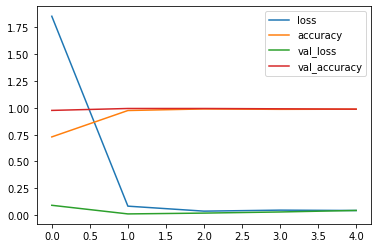

In [16]:
plot_loss_curves(history_simple_conv_net)

### Model 1

In [17]:
#Lets setup some callbacks
model1_tensorboard = tf.keras.callbacks.TensorBoard('/content/Experiments/model1')

In [18]:
#Create a base_model resnet
base_model = tf.keras.applications.ResNet152V2(include_top=False)
base_model.trainable = False

#Create inputs and outputs
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

#Create model
model1 = tf.keras.Model(inputs, outputs)

234545216/234545216 [==============================] - 11s 0us/step


In [21]:
#Compile model
model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

#Fit model
history_resent_model1 = model1.fit(train_data,
                                   epochs=5,
                                   steps_per_epoch=len(train_data),
                                   validation_data=test_data,
                                   validation_steps=int(len(test_data) * 0.15),
                                   callbacks=[model1_tensorboard])

Epoch 1/5
561/561 [==============================] - 149s 250ms/step - loss: 31.6996 - accuracy: 0.3362 - val_loss: 2.2703 - val_accuracy: 0.8036
Epoch 2/5
561/561 [==============================] - 135s 241ms/step - loss: 25.8949 - accuracy: 0.3587 - val_loss: 8.2102 - val_accuracy: 0.5089
Epoch 3/5
561/561 [==============================] - 136s 241ms/step - loss: 21.2795 - accuracy: 0.3960 - val_loss: 31.4436 - val_accuracy: 0.3080
Epoch 4/5
561/561 [==============================] - 135s 241ms/step - loss: 22.7997 - accuracy: 0.4141 - val_loss: 3.9654 - val_accuracy: 0.7277
Epoch 5/5
561/561 [==============================] - 136s 241ms/step - loss: 17.6203 - accuracy: 0.4642 - val_loss: 19.5528 - val_accuracy: 0.2574


In [22]:
#Evaluate model
results1 = model1.evaluate(test_data)
results1

141/141 [==============================] - 35s 245ms/step - loss: 13.4878 - accuracy: 0.5299


[13.487768173217773, 0.5298840403556824]

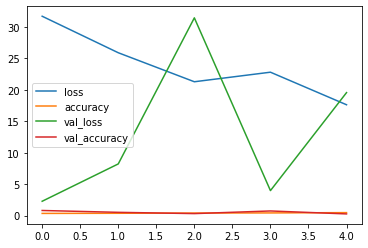

In [24]:
plot_loss_curves(history_resent_model1)

### Model 2

In [25]:
#Lets setup callbacks
model2_tensorboard = tf.keras.callbacks.TensorBoard(log_dir='/content/Experiments/model2')

In [26]:
#Create base_model mobilenet 
base_model = tf.keras.applications.MobileNetV2(include_top=False)
base_model.trainable = False    

#Create inputs and outputs
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

#Create model2
model2 = tf.keras.Model(inputs, outputs)

9406464/9406464 [==============================] - 0s 0us/step


In [27]:
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

history_mobilenet_model2 = model2.fit(train_data,
                                      epochs=5,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15*len(test_data)),
                                      callbacks=[model2_tensorboard])

Epoch 1/5
561/561 [==============================] - 47s 77ms/step - loss: 1.7583 - accuracy: 0.4279 - val_loss: 1.0881 - val_accuracy: 0.7515
Epoch 2/5
561/561 [==============================] - 40s 71ms/step - loss: 1.2124 - accuracy: 0.6536 - val_loss: 0.8731 - val_accuracy: 0.7827
Epoch 3/5
561/561 [==============================] - 41s 73ms/step - loss: 0.9723 - accuracy: 0.7372 - val_loss: 0.6740 - val_accuracy: 0.8333
Epoch 4/5
561/561 [==============================] - 49s 86ms/step - loss: 0.8264 - accuracy: 0.7842 - val_loss: 0.5272 - val_accuracy: 0.8750
Epoch 5/5
561/561 [==============================] - 44s 76ms/step - loss: 0.7305 - accuracy: 0.8107 - val_loss: 0.4429 - val_accuracy: 0.8973


In [28]:
results_model2 = model2.evaluate(test_data)
results_model2

141/141 [==============================] - 10s 67ms/step - loss: 0.7089 - accuracy: 0.8158


[0.7089287042617798, 0.8157894611358643]

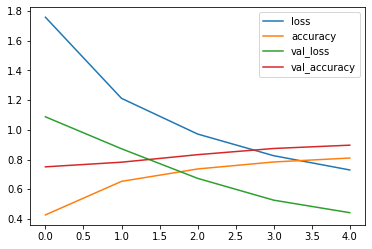

In [29]:
plot_loss_curves(history_mobilenet_model2)

### Model 3

In [30]:
#Lets setup callbacks for model3
model3_tensorboard = tf.keras.callbacks.TensorBoard(log_dir='/content/Experiments/model3')

In [31]:
#Lets setup base_model efficientnet
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False)
base_model.trainable = False

#Setup inputs and outputs
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

#Setup model3
model3 = tf.keras.Model(inputs, outputs)

52606240/52606240 [==============================] - 3s 0us/step


In [32]:
model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

history_efficientnet_model3 = model3.fit(train_data,
                                         epochs=5,
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=len(test_data),
                                         callbacks=[model3_tensorboard])

Epoch 1/5
561/561 [==============================] - 84s 129ms/step - loss: 1.1771 - accuracy: 0.6704 - val_loss: 0.8403 - val_accuracy: 0.7770
Epoch 2/5
561/561 [==============================] - 67s 118ms/step - loss: 0.6426 - accuracy: 0.8426 - val_loss: 0.6414 - val_accuracy: 0.8350
Epoch 3/5
561/561 [==============================] - 67s 119ms/step - loss: 0.4848 - accuracy: 0.8837 - val_loss: 0.5423 - val_accuracy: 0.8570
Epoch 4/5
561/561 [==============================] - 74s 132ms/step - loss: 0.4113 - accuracy: 0.9008 - val_loss: 0.3592 - val_accuracy: 0.9184
Epoch 5/5
561/561 [==============================] - 67s 118ms/step - loss: 0.3529 - accuracy: 0.9160 - val_loss: 0.3413 - val_accuracy: 0.9184


In [33]:
results_model3 = model3.evaluate(test_data)
results_model3

141/141 [==============================] - 13s 95ms/step - loss: 0.3413 - accuracy: 0.9184


[0.34131965041160583, 0.9183764457702637]

## Results

At the end of each experimet, lets see what accuracy they achieved 
- `model0` : 98%
- `model1` : 53%
- `model2` : 81%
- `model3` : 92%

Turns out the first model, just a simple CNN works the best with a high accuracy of 98%!

## Tensorboard Experiment tracking

In [35]:
!tensorboard dev upload --logdir '/content/Experiments' --one_shot

2023-02-25 02:15:25.199818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-25 02:15:25.199930: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-25 02:15:25.199949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/Experiments

This TensorB